<a href="https://colab.research.google.com/github/andreabazerla/real-estate/blob/main/Housing_Price_Prediction_in_Milan_(Italy)_through_Deep_Learning_via_immobiliare_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction in Milan (Italy) through Deep Learning via immobiliare.it

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import time
from google.colab import files
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
from decimal import Decimal
from scipy.stats import zscore

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def get_timestamp():
  return str(int(time.time()))

## Web Scraping: immobiliare.it

In [ ]:
import request
import datetime
import logging
from enum import Enum 
import os
import sys
import math
import locale
from random import uniform
from bs4 import BeautifulSoup

In [ ]:
PRODUCTION = True
GET_ADS_LINKS = False
GET_ADS_LIST = True

In [ ]:
class Contract(Enum):
  VENDITA = 'vendita'
  AFFITTO = 'affitto'
 
class Area(Enum):
  MILANO = 'milano'

In [ ]:
slash = '/'
https = 'https://'
website = 'www.immobiliare.it'
contract = Contract.VENDITA.value + '-case'
area = Area.MILANO.value
sort = '?criterio=rilevanza'
 
url = https + website + slash + contract + slash + area + slash + sort
 
print('url = ' + url)

In [ ]:
sleep_min = 2
sleep_max = 3

def sleep_default():
  time.sleep(uniform(sleep_min, sleep_max))

### Ads Link Scraping

In [ ]:
def get_last_page(url):
  sleep_default()
  
  try:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
  
    ul_pagination = soup.find("ul", class_ = "pagination pagination__number")
    li_list = ul_pagination.find_all("li")
    last_page = int(li_list[-1].get_text().strip())
  
    return last_page
  
  except requests.exceptions.RequestException as e:
    raise SystemExit(e)

In [ ]:
def get_ads_link_list(url, first_page, last_page):
  ads_link_list = []
  
  pag = first_page
  
  while (pag <= last_page):
    if (pag > 1):
      url = url + '&pag=' + str(pag)
    
    try:
      response = requests.get(url)

      soup = BeautifulSoup(response.content, 'html.parser')
    
      ads_list = soup.find('ul', class_ = 'annunci-list')
      ad_item_list = ads_list.find_all('div', class_ = 'listing-item_body--content')
      for ad_item in ad_item_list:
        a_list = ad_item.find_all("a")
        for a in a_list:
          href = a["href"]
          ads_link_list.append(href)
    
    except Exception as e:
      logging.exception(e)
      print(str(pag))
      pass
    
    pag += 1
 
    sleep_default()
  
  return ads_link_list

In [ ]:
if PRODUCTION:
  if GET_ADS_LINKS:
    first_page = 1
    #last_page = 631
    last_page = get_last_page(url)
  
    ads_link_list = get_ads_link_list(url, first_page, last_page)
    ads_link_list = list(dict.fromkeys(ads_link_list))
    
    print('Total number of ads = ' + str(len(ads_link_list)))

In [ ]:
df_links = pd.DataFrame({'Links' : list(ads_link_list)})

csv_links = 'Links_' + str(int(time.time())) + '_' + str(first_page) + '_' + str(last_page) + '.csv'
df_links.to_csv(csv_links, index=False)

In [ ]:
display(df_links)

In [ ]:
files.download(csv_links)

### Ads Scraping

In [ ]:
def get_ad_title(soup):
  titleBlock__title = soup.find('span', class_ = 'im-titleBlock__title')
  if titleBlock__title is not None:
    return titleBlock__title.get_text()
  else:
    return ''

In [ ]:
def get_ad_price(soup):
  mainFeatures__price = soup.find_all('li', class_ = 'im-mainFeatures__price')
  if mainFeatures__price:
    return mainFeatures__price[0].get_text().replace('\n', '').strip()
  else:
    return ''

In [ ]:
def get_ad_main_feature(soup):
  main_features = {}
  
  mainFeatures = soup.find('div', class_ = 'im-mainFeatures')
  
  li_list = mainFeatures.find_all('li')
  for li in li_list[1:]:
    value = li.find('span', class_="im-mainFeatures__value").get_text().replace('\n', '').strip()
    label = li.find('span', class_="im-mainFeatures__label").get_text().replace('\n', '').strip()
    
    if (label == 'bagno' or label == 'bagni'):
      label = 'bagni'
    
    if (label == 'locale' or label == 'locali'):
      label = 'locali'
    
    main_features[label] = value
  
  return main_features

In [ ]:
def get_ad_description(soup):
  description__text = soup.find('div', class_ = 'im-description__text')
  if description__text is not None:
    return description__text.get_text()
  else:
    return ''

In [ ]:
def get_ad_locations(soup):
  location_list = []
  
  titleBlock__link = soup.find('a', class_ = 'im-titleBlock__link')
  if titleBlock__link is None:
    titleBlock__link = soup.find('h1', class_ = 'im-titleBlock__content')

  location = titleBlock__link.find_all('span', class_ = 'im-location')
  
  try:
    area = location[0].get_text().strip()
  except IndexError:
    area = ''
  
  try:
    district = location[1].get_text().strip()
  except IndexError:
    district = ''

  try:
    address = location[2].get_text().strip()
  except IndexError:
    address = ''

  return [area, district, address]

In [ ]:
def get_ad_feature_list(soup):
  features = {}
  
  features__list = soup.find_all("dl", class_ = "im-features__list")
  
  for feature_block in features__list:
    feature__title_list = feature_block.find_all('dt', class_ = 'im-features__title')
  
    for feature__title in feature__title_list:
      feature__value = feature__title.findNext('dd')
  
      if ('im-features__tagContainer' in feature__value.get('class')):
        features__tag_array = []

        features__tag_list = soup.find_all('span', class_ = 'im-features__tag')
        for feature__tag in features__tag_list:
          features__tag_array.append(feature__tag.get_text().strip())
  
        features__tag_list_string = ','.join(features__tag_array)
        feature__value_2 = features__tag_list_string
  
      else:
        feature__value_2 = feature__value.get_text().strip()
  
      feature__title_2 = feature__title.get_text().strip()
      features['f_' + feature__title_2] = feature__value_2
  
  return features

In [ ]:
def get_ad(url):
  if 'p-' in url:
    return get_ad_multi(url)
  else:
    return get_ad_single(url)

In [ ]:
def get_ad_single(url):
  ads_list = []
  ad_data = {}

  ad_data['url'] = url

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, "html.parser")

      title = get_ad_title(soup);
      ad_data['titolo'] = title

      price = get_ad_price(soup);
      ad_data['prezzo'] = price

      main_features = get_ad_main_feature(soup)
      if main_features:
        ad_data.update(main_features)

      description = get_ad_description(soup);
      ad_data['descrizione'] = description

      area, district, address = get_ad_locations(soup)
      ad_data['area'] = area
      ad_data['quartiere'] = district
      ad_data['indirizzo'] = address

      feature_list = get_ad_feature_list(soup)
      if feature_list:
        ad_data.update(feature_list)

      ad_data['hashcode'] = hash(frozenset(ad_data.items()))

      ads_list.append(ad_data)
  
  except Exception as e:
    logging.exception(e)
    print(url)
    pass

  return ads_list

In [ ]:
def get_ad_multi(url):
  ads_list = []

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, 'html.parser')

      title = get_ad_title(soup);

      area, district, address = get_ad_locations(soup)

      main_features = get_ad_main_feature(soup)

      description = get_ad_description(soup)

      feature_list = get_ad_feature_list(soup)

      properties__list = soup.find('ul', class_ = 'im-properties__list')
      properties__item_list = properties__list.find_all('li', class_ = 'im-properties__item')
      for properties__item in properties__item_list:
        ad_data = {}

        ad_data['url'] = url

        ad_data['titolo'] = title

        ad_data['area'] = area
        ad_data['quartiere'] = district
        ad_data['indirizzo'] = address
        
        price = get_ad_price(properties__item)
        ad_data['prezzo'] = price

        ad_data['descrizione'] = description

        sub_features = get_ad_main_feature(properties__item)
        if sub_features:
          ad_data.update(sub_features)

        title_2 = properties__item.find('p', class_ = 'nd-mediaObject__title')
        if title_2 is not None:
          ad_data['titolo_2'] = title_2.get_text().strip()

        description_2 = properties__item.find('div', class_ = 'im-properties__content')
        if description_2 is not None:
          ad_data['descrizione_2'] = description_2.get_text()

        if feature_list:
          ad_data.update(feature_list)

        ad_data['hashcode'] = hash(frozenset(ad_data.items()))

        ads_list.append(ad_data)

  except Exception as e:
    logging.exception(e)
    print(url)
    pass
  
  return ads_list

In [ ]:
df_links = pd.read_csv('Links_1616797839_1_630.csv')
ads_link_list = df_links['Links'].to_list()

In [ ]:
if PRODUCTION:
  if GET_ADS_LIST:
    df_ads = pd.DataFrame()

    first_ad = 1000
    last_ad = 1500
    #last_ad = len(ads_link_list)

    #if (first_ad > last_ad)
    
    ads_csv = 'Ads_' + get_timestamp() + '_' + str(first_ad) + '_' + str(last_ad - 1) + '.csv'

    ads_list = []
    for i in tqdm(range(first_ad, last_ad)):

      try:
        ad_data = get_ad(ads_link_list[i])
        for ad in ad_data:
          ads_list.append(ad)
      except Exception as e:
        logging.exception(e)
        print(i)
        pass
      
      sleep_default()
    
    df_ads = pd.DataFrame(ads_list)
    df_ads.fillna('', inplace=True)
    df_ads.to_csv(ads_csv, index=False)

In [ ]:
  display(df_ads)

In [ ]:
files.download(ads_csv)

In [ ]:
ads_folder = 'Ads'
file_list = os.listdir(ads_folder)
ads_files = [file for file in file_list if file.startswith('Ads')]
ads_files.sort()

df_files = [None] * len(ads_files)
for idx, file in enumerate(ads_files):
  df_files[idx] = pd.read_csv(os.path.join(ads_folder, file))

df_final = pd.concat(df_files).drop_duplicates().reset_index(drop=True)

ads_csv_final = 'Ads' + '_' + get_timestamp() + '.csv'
df_final.to_csv(ads_csv_final, index=False)

In [ ]:
files.download(ads_csv_final)

## Clean Ads CSV

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
files.upload()

In [ ]:
csv_ads = 'Ads_1617101603.csv'
df_ads = pd.read_csv(csv_ads, dtype=str)

In [ ]:
print(df_ads.info())
display(df_ads.describe().transpose())
display(df_ads.head(10).T)

In [ ]:
df_ads['id'] = range(1, len(df_ads) + 1)
df_ads.set_index('id', inplace = True)

df_ads = df_ads[~df_ads['url'].str.contains('p-')]

index_names = df_ads[
  (df_ads['f_offerta minima'].notnull())
  | (df_ads['f_rialzo minimo'].notnull())
  | (df_ads['f_Spesa prenota debito'].notnull())
  | (df_ads['f_Contributo non dovuto'].notnull())
  | (df_ads['f_Tribunale'].notnull())
  | (df_ads['f_termine presentazione'].notnull())
  | (df_ads['f_lotto numero'].notnull())
  | (df_ads['f_Deposito cauzionale'].notnull())
  | (df_ads['f_luogo vendita'].notnull())
  | (df_ads['f_Luogo presentazione'].notnull())
  | (df_ads['f_categoria'].notnull())
  | (df_ads['f_Procedura'].notnull())
  | (df_ads['f_Procedura'].notnull())
  | (df_ads['f_numero procedura'].notnull())
  | (df_ads['f_Delegato'].notnull())
  | (df_ads['f_Giudice'].notnull())
  | (df_ads['f_Custode'].notnull())
  | (df_ads['f_Dati catastali'].notnull())
  | (df_ads['f_Rialzo minimo in caso di gara'].notnull())
  | (df_ads['f_Motivo esenzione'].notnull())
  | (df_ads['f_note'].notnull())
  | (df_ads['f_Rito'].notnull())
  | (df_ads['f_Curatore'].notnull())
  | (df_ads['f_Altri dati catastali'].notnull())
  | (df_ads['f_Deposito conto spese'].notnull())
  | (df_ads['f_Cauzione e spese'].notnull())
  | (df_ads['f_Referente'].notnull())
  | (df_ads['f_valore perizia'].notnull())
  | (df_ads['f_Delegato alla vendita'].notnull())
].index

df_ads = df_ads.drop(index_names)

columns_useless = [
  'url',
  'area',
  'descrizione',
  'titolo_2',
  'descrizione_2',
  'f_superficie',
  'f_prezzo',
  'f_riferimento e Data annuncio',
  'f_immobile garantito',
  'f_contratto',
  'f_unità',
  'f_Data di inizio lavori e di consegna prevista',
  'f_Indice prest. energetica rinnovabile',
  'f_Prestazione energetica del fabbricato',
  'f_disponibilità',
  'f_certificazione energetica',
  'f_numero immobili',
  'f_aggiornato il',
  'hashcode',
  'data vendita',
  'f_Tipo vendita',
  'f_data vendita',
  'f_offerta minima',
  'f_rialzo minimo',
  'f_Spesa prenota debito',
  'f_Contributo non dovuto',
  'f_Tribunale',
  'f_termine presentazione',
  'f_lotto numero',
  'f_Deposito cauzionale',
  'f_luogo vendita',
  'f_Luogo presentazione',
  'f_categoria',
  'f_Procedura',
  'f_numero procedura',
  'f_Delegato',
  'f_Giudice',
  'f_Custode',
  'f_Dati catastali',
  'f_Rialzo minimo in caso di gara',
  'f_Motivo esenzione',
  'f_note',
  'f_Rito',
  'f_Curatore',
  'f_Altri dati catastali',
  'f_Deposito conto spese',
  'f_Cauzione e spese',
  'f_Referente',
  'f_valore perizia',
  'f_Delegato alla vendita'
]

df_ads = df_ads.drop(columns_useless, axis=1)

df_ads = df_ads[~df_ads['prezzo'].str.contains('da', na=False)]

columns_unique_treshold = df_ads[['quartiere']]
df_ads = df_ads[columns_unique_treshold.replace(columns_unique_treshold.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_2 = df_ads[['f_stato']]
df_ads = df_ads[columns_unique_treshold_2.replace(columns_unique_treshold_2.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_3 = df_ads[['f_Tipo proprietà']]
df_ads = df_ads[columns_unique_treshold_3.replace(columns_unique_treshold_3.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_4 = df_ads[['f_tipologia']]
df_ads = df_ads[columns_unique_treshold_4.replace(columns_unique_treshold_4.apply(pd.Series.value_counts)).gt(10).all(1)]

df_ads = df_ads[df_ads['f_Tipo proprietà'].notna()]
df_ads['c_Tipo proprietà'] = df_ads['f_Tipo proprietà'].str.extract(r"(Intera proprietà|Multiproprietà|Usufrutto|Diritto di superficie|Parziale proprietà|Nuda proprietà)", flags = re.IGNORECASE)
df_ads['c_Classe proprietà'] = df_ads['f_Tipo proprietà'].str.extract(r"(classe immobile economica|classe immobile media|classe immobile signorile|immobile di lusso)", flags = re.IGNORECASE)
df_ads['c_Tipo proprietà'] = df_ads['c_Tipo proprietà'].str.lower().str.strip()
df_ads['c_Classe proprietà'] = df_ads['c_Classe proprietà'].str.lower().str.strip()
df_ads = df_ads[df_ads['c_Tipo proprietà'].notna()]
df_ads = df_ads[df_ads['c_Classe proprietà'].notna()]

df_ads['f_tipologia'] = df_ads['f_tipologia'].str.lower().str.strip()
df_ads = df_ads[df_ads['f_tipologia'].notna()]

df_ads['quartiere'] = df_ads['quartiere'].str.lower().str.strip()
df_ads = df_ads[df_ads['quartiere'].notna()]

df_ads = df_ads[df_ads['f_stato'].notna()]
df_ads['c_stato'] = df_ads['f_stato'].str.extract(r"(Da ristrutturare|Nuovo \/ In costruzione|Buono \/ Abitabile|Ottimo \/ Ristrutturato)", flags = re.IGNORECASE)
df_ads['c_stato'] = df_ads['f_stato'].str.lower().str.strip()
df_ads = df_ads[df_ads['c_stato'].notna()]

df_ads = df_ads[df_ads['f_Efficienza energetica'].notna()]

df_ads['prezzo'] = df_ads['prezzo'].replace('[\€\.]', '', regex=True).replace(',00', '')
df_ads['prezzo'] = df_ads['prezzo'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['prezzo'].notna()]
df_ads['prezzo'] = df_ads['prezzo'].astype(int)

prezzo_filtered = abs(zscore(df_ads['prezzo'])) < 3
df_ads = df_ads[prezzo_filtered]
df_ads = df_ads[df_ads['prezzo'] > 10000]

df_ads['superficie'] = df_ads['superficie'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['superficie'].notna()]
df_ads['superficie'] = df_ads['superficie'].astype(int)

df_ads['bagni'] = df_ads['bagni'].str.extract(r'(1|2|3\+|3)')
df_ads['bagni'] = df_ads['bagni'].fillna('0')
df_ads['bagni'] = df_ads['bagni'].astype(str)

df_ads['locali'] = df_ads['locali'].str.extract(r"(1|2|3|4|5\+|5)")
df_ads = df_ads[df_ads['locali'].notna()]
df_ads['locali'] = df_ads['locali'].astype(str)

df_ads['c_camere da letto'] = df_ads['f_locali'].str.extract(r"(\d\scamer[a,e] da letto)", flags = re.IGNORECASE)
df_ads['c_altri locali'] = df_ads['f_locali'].str.extract(r"(\d\saltr[o,i])", flags = re.IGNORECASE)

df_ads = df_ads[df_ads['c_camere da letto'].notna()]
df_ads = df_ads[df_ads['c_altri locali'].notna()]

df_ads['c_calcolo numero locali'] = df_ads['c_camere da letto'].str.extract(r"(\d)").astype(int) + df_ads['c_altri locali'].str.extract(r"(\d)").astype(int)

df_ads['c_numero totale locali'] = df_ads['locali']
df_ads.loc[df_ads['c_numero totale locali'] == '5+', 'c_numero totale locali'] = df_ads['c_calcolo numero locali']
df_ads['c_numero totale locali'] = df_ads['c_numero totale locali'].astype(int)

df_ads['c_camere da letto'] = df_ads['c_camere da letto'].str.extract(r"(\d)").astype(int)
df_ads['c_altri locali'] = df_ads['c_altri locali'].str.extract(r"(\d)").astype(int)

df_ads['c_numero totale locali'] = df_ads['c_numero totale locali'].astype(int)

df_ads.drop(['c_calcolo numero locali'], axis=1, inplace=True)

df_ads['c_tipo cucina'] = df_ads['f_locali'].str.extract(r"(cucina abitabile|cucina a vista|cucina angolo cottura|cucina cucinotto|cucina semi abitabile)", flags = re.IGNORECASE)
df_ads['c_tipo cucina'] = df_ads['c_tipo cucina'].str.lower().str.strip().fillna('')

df_ads['c_campo da tennis'] = df_ads['f_locali'].str.contains("campo da tennis").astype(int).astype(str)

df_ads['f_spese condominio'] = df_ads['f_spese condominio'].str.extract(r'(\d+)')
df_ads['f_spese condominio'] = df_ads['f_spese condominio'].fillna(0)
df_ads['f_spese condominio'] = df_ads['f_spese condominio'].astype(int)

df_ads['f_totale piani edificio'] = df_ads['f_totale piani edificio'].str.extract(r'(\d+)')
df_ads = df_ads[df_ads['f_totale piani edificio'].notna()]
df_ads['f_totale piani edificio'] = df_ads['f_totale piani edificio'].astype(int)
df_ads = df_ads[(df_ads['f_totale piani edificio'] < 44)]

df_ads = df_ads[df_ads['f_anno di costruzione'].notna()]
df_ads['f_anno di costruzione'] = df_ads['f_anno di costruzione'].astype(float).astype(int)

df_ads['f_altre caratteristiche'] = df_ads['f_altre caratteristiche'].str.split(',')
df_ads['f_altre caratteristiche'] = df_ads['f_altre caratteristiche'].fillna('')

df_ads = df_ads[df_ads['f_Efficienza energetica'].notna()]
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica'].str.extract(r"(^[A-Z][\+]?[\d]?)", flags = re.IGNORECASE)
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica tipo'].str.upper()
df_ads['f_Efficienza energetica tipo'] = df_ads['f_Efficienza energetica tipo'].str.strip()
df_ads = df_ads[df_ads['f_Efficienza energetica tipo'].notna()]

df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica'].str.extract(r"(\d+[,]?\d+)", flags = re.IGNORECASE)
df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica valore'].replace('[\,]', '.', regex=True)
df_ads['f_Efficienza energetica valore'] = df_ads['f_Efficienza energetica valore'].str.strip().astype(float)
df_ads = df_ads[df_ads['f_Efficienza energetica valore'].notna()]

regex_address = "((?:alzaia|arco|autostrada|belvedere|calata|calle|cavalcavia|circonvallazione|corso|corte|cortile|discesa|foro|galleria|gradinata|larghetto|largo|litoranea|lungargine|lungofiume|lungolago|lungomare|lungoparco|lungotorrente|molo|parcheggio|passaggio|passeggiata|percorso ciclabile|percorso ciclopedonale|percorso pedonale|piazza|piazzale|piazzetta|pista ciclabile|ponte|raccordo|rampa|ripa|ronco|rotatoria|rotonda|salita|scalinata|scesa|sentiero|slargo|sottopasso|sovrappasso|spiazzo|strada|strada antica|strada comunale|strada consortile|strada nuova|strada panoramica|strada poderale|strada privata|strada provinciale|strada regionale|strada statale|strada vecchia|strada vicinale|stradella|stradello|stradone|tangenziale|traversa|traversa privata|via|via antica|via comunale|via nazionale|via nuova|via panoramica|via privata|via provinciale|via vecchia|viale|vialetto|vico|vico chiuso|vico cieco|vico privato|vicoletto|vicolo|vicolo chiuso|vicolo cieco|vicolo privato|viottolo)\s+[\d]*[\u00c4-\u00e4\u00d6-\u00f6-\u00dc-\u00fc-\u00dfa-zA-Z-'\s\.]*[,\s]*[\d]+[\w-]*)"
df_ads['indirizzo_2'] = df_ads['titolo'].str.extract(regex_address, flags = re.IGNORECASE)
df_ads['indirizzo_2'] = df_ads['indirizzo_2'] + ', milano'
df_ads['indirizzo_2'] = df_ads['indirizzo_2'].str.lower().str.strip()
df_ads['indirizzo_2'] = df_ads['indirizzo_2'].fillna('')

df_ads['g_garage/box'] = df_ads['f_Posti Auto'].str.extract(r"(\d\sin garage\/box)", flags = re.IGNORECASE)
df_ads['e_all\'esterno'] = df_ads['f_Posti Auto'].str.extract(r"(\d\sall'esterno)", flags = re.IGNORECASE)
df_ads['g_garage/box'] = df_ads['g_garage/box'].str.extract(r'(\d+)')
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].str.extract(r'(\d+)')
df_ads['g_garage/box'] = df_ads['g_garage/box'].fillna(0)
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].fillna(0)
df_ads['g_garage/box'] = df_ads['g_garage/box'].astype(int)
df_ads['e_all\'esterno'] = df_ads['e_all\'esterno'].astype(int)
df_ads['c_garage number'] = df_ads['g_garage/box'] + df_ads['e_all\'esterno']

df_ads['f_ascensore'] = df_ads['f_piano'].apply(lambda x: '1' if (pd.notna(x) and 'con ascensore' in x) else '0')
df_ads['f_disabili'] = df_ads['f_piano'].apply(lambda x: '1' if (pd.notna(x) and 'con accesso disabili' in x) else '0')

df_ads['c_Climatizzazione impianto'] = df_ads['f_Climatizzazione'].str.extract(r"(Autonomo|Centralizzato|Predisposizione impianto)", flags = re.IGNORECASE)
df_ads['c_Climatizzazione impianto'] = df_ads['c_Climatizzazione impianto'].str.lower().str.strip().fillna('')

df_ads['c_Climatizzazione tipo'] = df_ads['f_Climatizzazione'].str.extract(r"(freddo/caldo|freddo|caldo)", flags = re.IGNORECASE)
df_ads['c_Climatizzazione tipo'] = df_ads['c_Climatizzazione tipo'].str.lower().str.strip().fillna('')

df_ads['c_riscaldamento impianto'] = df_ads['f_riscaldamento'].str.extract(r"(Centralizzato|Autonomo)", flags = re.IGNORECASE)
df_ads['c_riscaldamento impianto'] = df_ads['c_riscaldamento impianto'].str.lower().str.strip().fillna('')

df_ads['c_riscaldamento tipo'] = df_ads['f_riscaldamento'].str.extract(r"(a pavimento|a radiatori|ad aria|a stufa)", flags = re.IGNORECASE)
df_ads['c_riscaldamento tipo'] = df_ads['c_riscaldamento tipo'].str.lower().str.strip().fillna('')

df_ads['c_riscaldamento alimentazione'] = df_ads['f_riscaldamento'].str.extract(r"(alimentato a metano|alimentato a gasolio|alimentato a gas|alimentato a pompa di calore|alimentato a gpl|alimentato a teleriscaldamento|alimentazione elettrica|alimentato a fotovoltaico|alimentato a solare|alimentato a pellet)", flags = re.IGNORECASE)
df_ads['c_riscaldamento alimentazione'] = df_ads['c_riscaldamento alimentazione'].str.lower().str.strip().fillna('')

mlb = MultiLabelBinarizer()
df_ads = df_ads.join(
  pd.DataFrame(mlb.fit_transform(df_ads.pop('f_altre caratteristiche')),
  columns=mlb.classes_,
  index=df_ads.index).add_prefix('c_'))

columns_caratteristiche = [
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono'
]

df_ads[columns_caratteristiche] = df_ads[columns_caratteristiche].astype(str)

df_ads = df_ads.drop('titolo', axis=1)
df_ads = df_ads.drop('indirizzo', axis=1)
df_ads = df_ads.drop('f_locali', axis=1)
df_ads = df_ads.drop('f_piano', axis=1)
df_ads = df_ads.drop('f_Tipo proprietà', axis=1)
df_ads = df_ads.drop('f_tipologia', axis=1)
df_ads = df_ads.drop('f_stato', axis=1)
df_ads = df_ads.drop('f_Climatizzazione', axis=1)
df_ads = df_ads.drop('f_riscaldamento', axis=1)
df_ads = df_ads.drop('f_Posti Auto', axis=1)
df_ads = df_ads.drop('f_Efficienza energetica', axis=1)

In [ ]:
display(df_ads.info())
display(df_ads.describe().transpose())
display(df_ads.head(5).T)

In [ ]:
csv_ads_clean = 'Ads_clean_' + get_timestamp() + '.csv'
df_ads.to_csv(csv_ads_clean, index=False)
files.download(csv_ads_clean)

In [ ]:
'''
dictionary = {}
column = 'c_tipo cucina'
sum = 0
for index, row in df_ads_columns.iterrows():
  cell = row[column]
  sum += 1
  if not cell in dictionary:
    dictionary[cell] = 1
  else:
    dictionary[cell] += 1

print(sum)

print(sorted(dictionary.items(), key=lambda x:x[1]))
'''

## Geocoder

In [ ]:
from geopy import distance
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
files.upload()

In [ ]:
csv_ads_clean = 'Ads_clean_1618605615.csv'
df_ads_geo = pd.read_csv(csv_ads_clean)

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

tqdm.pandas()

df_ads_geo = df_ads.copy()

df_ads_geo['indirizzo_geocode'] = df_ads_geo['indirizzo_2'].progress_apply(geocode)
df_ads_geo['point'] = df_ads_geo['indirizzo_geocode'].apply(lambda loc: tuple(loc.point) if loc else None)
df_ads_geo[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_ads_geo['point'].tolist(), index=df_ads_geo.index)

#df_ads_geo.drop('indirizzo_geocode', axis=1)
#df_ads_geo.drop('point', axis=1)
#df_ads_geo.drop('altitude', axis=1)

In [ ]:
csv_ads_geo = 'Ads_geo_1618621216.csv'
df_ads_geo = pd.read_csv(csv_ads_geo)

In [ ]:
#N = 45.5390
#E = 9.2927
#S = 45.3762
#W = 9.0651

df_ads_geo.loc[(df_ads_geo['latitude'] < 45.3762) | (df_ads_geo['latitude'] > 45.5390) | (df_ads_geo['longitude'] < 9.0651) | (df_ads_geo['longitude'] > 9.2927), ['latitude', 'longitude']] = np.nan

In [ ]:
DUOMO_DI_MILANO = (45.4641, 9.1919)
CASTELLO_SFORZESCO = (45.4704, 9.1793)
GALLERIA_VITTORIO_EMANUALE_II = (45.4658, 9.1899)
TEATRO_LA_SCALA = (45.4674, 9.1895)
ARCO_DELLA_PACE = (45.4756, 9.1724)
STADIO_SAN_SIRO = (45.4781, 9.1239)
STAZIONE_CENTRALE = (45.4849, 9.2033)

def calc_distance(from_loc, to_lat, to_long):
  if not math.isnan(to_lat) and not math.isnan(to_long):
    return distance.distance(from_loc, (to_lat, to_long)).km
  else:
    pass

def get_distance(df, column_name, from_location):
  df[column_name] = df.apply(lambda row: calc_distance(from_location, row.latitude, row.longitude), axis=1)
  return df

df_ads_geo = get_distance(df_ads_geo, 'distance_duomo', DUOMO_DI_MILANO)
#df_ads_geo = get_distance(df_ads_geo, 'distance_castello', CASTELLO_SFORZESCO)
#df_ads_geo = get_distance(df_ads_geo, 'distance_galleria', GALLERIA_VITTORIO_EMANUALE_II)
#df_ads_geo = get_distance(df_ads_geo, 'distance_scala', TEATRO_LA_SCALA)
#df_ads_geo = get_distance(df_ads_geo, 'distance_arco', ARCO_DELLA_PACE)
#df_ads_geo = get_distance(df_ads_geo, 'distance_stadio', STADIO_SAN_SIRO)
#df_ads_geo = get_distance(df_ads_geo, 'distance_centrale', STAZIONE_CENTRALE)

In [ ]:
df_ads_geo.info()
display(df_ads_geo.describe().transpose())
display(df_ads_geo.head(5).T)

In [ ]:
csv_ads_geo = 'Ads_geo_' + get_timestamp() + '.csv'
df_ads_geo.to_csv(csv_ads_geo, index=False)
files.download(csv_ads_geo)

## Exploratory Data Analysis (EDA)

In [ ]:
!pip install dython

import dython
from dython.nominal import correlation_ratio
from dython.nominal import associations

import folium
from folium.plugins import HeatMap

In [ ]:
files.upload()

In [ ]:
csv_ads_clean = 'Ads_clean_1619100850.csv'
df_ads_clean = pd.read_csv(csv_ads_clean)

In [ ]:
#df_ads_clean = df_ads

In [ ]:
#df_ads_clean = df_ads_geo

In [ ]:
display(df_ads_clean.info())
display(df_ads_clean.describe().transpose())
display(df_ads_clean.head(10).T)

In [ ]:
#list(df_ads_clean.columns.values)
#df_ads_clean.dtypes

columns_filtered = [
  'prezzo',
  'quartiere',
  'superficie',
  'bagni',
  #'piano',
  'locali',
  'f_totale piani edificio',
  'f_spese condominio',
  'f_anno di costruzione',
  'c_Tipo proprietà',
  'c_Classe proprietà',
  'c_stato',
  'c_camere da letto',
  'c_altri locali',
  'c_numero totale locali',
  'c_tipo cucina',
  'c_campo da tennis',
  'f_Efficienza energetica tipo',
  'f_Efficienza energetica valore',
  #'indirizzo_2',
  'g_garage/box',
  "e_all'esterno",
  'c_garage number',
  'f_ascensore',
  'f_disabili',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_riscaldamento impianto',
  'c_riscaldamento tipo',
  'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono'
]

columns_geo = [
  'distance_duomo',
  'distance_castello',
  'distance_galleria',
  'distance_scala',
  'distance_arco'
]

#columns_filtered = columns_filtered + columns_geo 

columns_nominal = [
  'quartiere',
  'bagni',
  'piano',
  'locali',
  'c_Tipo proprietà',
  'c_Classe proprietà',
  'c_stato',
  'c_tipo cucina',
  'c_campo da tennis',
  'f_Efficienza energetica tipo',
  #'indirizzo_2',
  'f_ascensore',
  'f_disabili',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_riscaldamento impianto',
  'c_riscaldamento tipo',
  'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  'c_Arredato',
  'c_Balcone',
  'c_Caminetto',
  'c_Cancello elettrico',
  'c_Cantina',
  'c_Esposizione doppia',
  'c_Esposizione esterna',
  'c_Esposizione interna',
  'c_Fibra ottica',
  'c_Giardino comune',
  'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  'c_Impianto tv centralizzato',
  'c_Impianto tv con parabola satellitare',
  'c_Impianto tv singolo',
  'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  'c_Infissi esterni in doppio vetro / metallo',
  'c_Infissi esterni in triplo vetro / PVC',
  'c_Infissi esterni in triplo vetro / legno',
  'c_Infissi esterni in triplo vetro / metallo',
  'c_Infissi esterni in vetro / PVC',
  'c_Infissi esterni in vetro / legno',
  'c_Infissi esterni in vetro / metallo',
  'c_Mansarda',
  'c_Parzialmente Arredato',
  'c_Piscina',
  'c_Porta blindata',
  'c_Portiere intera giornata',
  'c_Portiere mezza giornata',
  'c_Reception',
  'c_Solo Cucina Arredata',
  'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono'
]

ADS_FILTERED = False

if ADS_FILTERED:
  df_ads_clean_alias = df_ads_clean[df_ads_clean['c_Classe proprietà'] == 'classe immobile signorile']
  df_ads_clean_alias = df_ads_clean[df_ads_clean.point.notnull()]
else:
  df_ads_clean_alias = df_ads_clean.copy()

df_ads_clean_alias = df_ads_clean_alias[columns_filtered]

print(len(df_ads_clean_alias.index))

associations_dictionary = associations(df_ads_clean_alias, nan_strategy='replace', nan_replace_value='', nominal_columns=columns_nominal, figsize=(50, 50), cmap='seismic', mark_columns=False)

associations_corr = associations_dictionary['corr']

In [ ]:
corr_threshold = 0.15

#corr_price = associations_corr['prezzo (con)']
corr_price = associations_corr['prezzo']
corr_price_filtered = corr_price[abs(corr_price) >= corr_threshold]

corr_top = corr_price_filtered.sort_values(ascending = False).to_frame()
#corr_top = corr_top.head(100)

display(corr_top)

corr_top_t = corr_top.T

columns_to_drop = [column for column in corr_top_t.columns if any(corr_top_t[column] > corr_threshold)]

display(columns_to_drop)

In [ ]:
corr_graph = associations_corr[abs(associations_corr) >= corr_threshold]

plt.figure(figsize=(50, 50))
sb.heatmap(corr_graph, cmap="Greens", square=True, vmin=0, vmax=1, annot=True)

In [ ]:
df_ads_clean.hist(figsize = (50, 50))
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 15))

fig.add_subplot(2, 2, 1)
locali_order = ['5+', '5', '4', '3', '2', '1']
sb.scatterplot(x='superficie', y='prezzo', data=df_ads_clean, hue="locali", hue_order=locali_order, palette='hot')

fig.add_subplot(2, 2, 2)
eet_order = ['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
sb.scatterplot(x='f_spese condominio', y='prezzo', data=df_ads_clean, hue='f_Efficienza energetica tipo', hue_order=eet_order, palette='copper')

fig.add_subplot(2, 2, 3)
eet_order = ['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
sb.scatterplot(x='f_anno di costruzione', y='prezzo', data=df_ads_clean, hue='f_Efficienza energetica tipo', hue_order=eet_order, palette='copper')

fig.add_subplot(2, 2, 4)
bagni_order = ['3+', '3', '2', '1', '0']
sb.scatterplot(x='c_numero totale locali', y='prezzo', data=df_ads_clean, hue='bagni', hue_order=bagni_order, palette='copper')

In [ ]:
list(df_ads_clean.columns)

In [ ]:
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

#plt.xlim(0, 5000000)

sb.histplot(df_ads_clean['prezzo'], ax=ax, binwidth=100000, kde=True)

plt.title('Prezzo')

plt.xlabel('Prezzo')
plt.ylabel('Frequency')

In [ ]:
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sb.boxplot(x=df_ads_clean['prezzo'], ax=ax)

In [ ]:
def generateBaseMap(default_location=[45.4641, 9.1919], default_zoom_start=12):
  base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
  return base_map

base_map = generateBaseMap()
HeatMap(data=df_ads_clean[['latitude', 'longitude', 'prezzo']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=17, max_zoom=5, max_val=df_ads_clean['prezzo'].max()).add_to(base_map)
base_map

## Artificial Neural Network

In [29]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, InputLayer
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import feature_selection

### One-Hot Encoding

In [ ]:
files.upload()

In [ ]:
csv_ads_clean = 'Ads_clean_1619166011.csv'
df_ads_clean = pd.read_csv(csv_ads_clean)
df_ads_hot = df_ads_clean.copy()

In [ ]:
#df_ads_hot = df_ads_clean

In [ ]:
#df_ads_hot = df_ads_geo

In [ ]:
'''
  'prezzo',
  'superficie',
  'bagni',
  'locali',
  'c_numero totale locali',
  'c_camere da letto',
  'quartiere',
  'c_altri locali',
  'c_Classe proprietà',
  'f_spese condominio',
  'c_tipo cucina',
  'c_Impianto di allarme',
  'c_Caminetto',
  'c_garage number',
  'c_Terrazza',
  'g_garage/box',
  'c_Idromassaggio',
  'c_Portiere intera giornata',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  'c_Infissi esterni in doppio vetro / legno',
  'c_VideoCitofono',
  "e_all'esterno",
  'c_Armadio a muro'
'''

columns_filtered = [
  'prezzo',
  'quartiere',
  'superficie',
  'bagni',
  #'piano',
  #'locali',
  #'f_totale piani edificio',
  'f_spese condominio',
  #'f_anno di costruzione',
  #'c_Tipo proprietà',
  'c_Classe proprietà',
  #'c_stato',
  #'c_camere da letto',
  #'c_altri locali',
  'c_numero totale locali',
  'c_tipo cucina',
  #'c_campo da tennis',
  #'f_Efficienza energetica tipo',
  #'f_Efficienza energetica valore',
  #'indirizzo_2',
  #'g_garage/box',
  #"e_all'esterno",
  'c_garage number',
  #'f_ascensore',
  #'f_disabili',
  'c_Climatizzazione impianto',
  'c_Climatizzazione tipo',
  #'c_riscaldamento impianto',
  #'c_riscaldamento tipo',
  #'c_riscaldamento alimentazione',
  'c_Armadio a muro',
  #'c_Arredato',
  #'c_Balcone',
  'c_Caminetto',
  #'c_Cancello elettrico',
  #'c_Cantina',
  #'c_Esposizione doppia',
  #'c_Esposizione esterna',
  #'c_Esposizione interna',
  #'c_Fibra ottica',
  #'c_Giardino comune',
  #'c_Giardino privato',
  'c_Idromassaggio',
  'c_Impianto di allarme',
  #'c_Impianto tv centralizzato',
  #'c_Impianto tv con parabola satellitare',
  #'c_Impianto tv singolo',
  #'c_Infissi esterni in doppio vetro / PVC',
  'c_Infissi esterni in doppio vetro / legno',
  #'c_Infissi esterni in doppio vetro / metallo',
  #'c_Infissi esterni in triplo vetro / PVC',
  #'c_Infissi esterni in triplo vetro / legno',
  #'c_Infissi esterni in triplo vetro / metallo',
  #'c_Infissi esterni in vetro / PVC',
  #'c_Infissi esterni in vetro / legno',
  #'c_Infissi esterni in vetro / metallo',
  #'c_Mansarda',
  #'c_Parzialmente Arredato',
  #'c_Piscina',
  #'c_Porta blindata',
  'c_Portiere intera giornata',
  #'c_Portiere mezza giornata',
  #'c_Reception',
  #'c_Solo Cucina Arredata',
  #'c_Taverna',
  'c_Terrazza',
  'c_VideoCitofono'
]

df_ads_hot = df_ads_hot.filter(items=columns_filtered)

In [ ]:
list(df_ads_hot.columns)

In [ ]:
'''
superficie (con)                                   0.777779
bagni (nom)                                        0.685310
locali (nom)                                       0.653241
c_numero totale locali (con)                       0.644259
c_camere da letto (con)                            0.591606
quartiere (nom)                                    0.567728
c_altri locali (con)                               0.447885
c_Classe proprietà (nom)                           0.444798
f_spese condominio (con)                           0.349314
c_tipo cucina (nom)                                0.312352
c_Impianto di allarme (nom)                        0.306474
c_Caminetto (nom)                                  0.298258
c_garage number (con)                              0.271772
c_Terrazza (nom)                                   0.260097
g_garage/box (con)                                 0.248640
c_Idromassaggio (nom)                              0.246640
c_Portiere intera giornata (nom)                   0.217231
c_Climatizzazione impianto (nom)                   0.193296
c_Climatizzazione tipo (nom)                       0.187758
c_Infissi esterni in doppio vetro / legno (nom)    0.182985
c_VideoCitofono (nom)                              0.161396
e_all'esterno (con)                                0.156582
c_Armadio a muro (nom)                             0.152824
c_Esposizione doppia (nom)                         0.148442
f_Efficienza energetica tipo (nom)                 0.137522
f_ascensore (nom)                                  0.136469
c_Infissi esterni in doppio vetro / PVC (nom)      0.133662
c_Esposizione interna (nom)                        0.124821
c_Taverna (nom)                                    0.116011
c_Piscina (nom)                                    0.115519
f_totale piani edificio (con)                      0.113404
c_Impianto tv con parabola satellitare (nom)       0.109794
c_riscaldamento tipo (nom)                         0.109598
c_Cantina (nom)                                    0.103767
c_stato (nom)                                      0.101350
c_Giardino privato (nom)                           0.101008
f_anno di costruzione (con)                       -0.128607
'''

columns_to_drop.remove('prezzo')
df_ads_hot = df_ads_hot.drop(columns_to_drop, axis=1)

In [ ]:
dummies_dict = {
  ('c_Climatizzazione tipo', 'ct'),
  #('locali', 'l'),
  ('bagni', 'b'),
  ('quartiere', 'q'),
  ('c_tipo cucina', 'tc'),
  ('c_Classe proprietà', 'cp'),
  #('f_Efficienza energetica tipo', 'eet'),
  #('c_Tipo proprietà', 'tp'),
  #('piano', 'p'),
  #('c_stato', 's'),
  ('c_Climatizzazione impianto', 'ci'),
  #('c_riscaldamento impianto', 'ri'),
  #('c_riscaldamento tipo', 'rt'),
  #('c_riscaldamento alimentazione', 'ra')
}

def dummies(df, dummies_dict):
  for column in dummies_dict:
    df = pd.concat([df, pd.get_dummies(df[column[0]], prefix=column[1])], axis=1)
    df.drop([column[0]], axis=1, inplace=True)
  return df

df_ads_hot = dummies(df_ads_hot, dummies_dict)

In [ ]:
print(df_ads_hot.info())
display(df_ads_hot.describe().transpose())
display(df_ads_hot.head(10).T)

In [ ]:
csv_ads_hot = 'Ads_hot_' + get_timestamp() + '.csv'
df_ads_hot.to_csv(csv_ads_hot, index=False)
files.download(csv_ads_hot)

### Training

In [59]:
!pip install h5py
!pip install -U keras-tuner

import tensorflow as tf

import kerastuner as kt
from kerastuner.tuners import Hyperband
from kerastuner import HyperModel

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
files.upload()

In [6]:
csv_ads_hot = 'Ads_hot_1619214970.csv'
df_ads_hot = pd.read_csv(csv_ads_hot)

In [7]:
cols = df_ads_hot.columns
for col in cols:
  df_ads_hot[col] = df_ads_hot[col].astype(float)

In [ ]:
print(df_ads_hot.info())
display(df_ads_hot.describe().transpose())
display(df_ads_hot.head(10).T)

In [ ]:
print(len(df_ads_hot.index))

df_ads_hot = df_ads_hot[df_ads_hot['cp_classe immobile signorile'] == 1]
df_ads_hot = df_ads_hot[df_ads_hot['superficie'] < 200]
df_ads_hot = df_ads_hot[df_ads_hot['b_3+'] != 1.0]
df_ads_hot = df_ads_hot[df_ads_hot['c_numero totale locali'] < 6]
#df_ads_hot = df_ads_hot[df_ads_hot['l_5+'] != 1.0]

print(len(df_ads_hot.index))

In [8]:
print(df_ads_hot.shape)

df_ads_hot = df_ads_hot.dropna()

print(df_ads_hot.shape)

(7815, 174)
(7815, 174)


In [48]:
X = df_ads_hot.drop('prezzo', axis=1)
y = df_ads_hot[['prezzo']]

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5)

In [11]:
columns_standard = [
  'superficie',
  #'f_totale piani edificio',
  'f_spese condominio',
  #'f_anno di costruzione',
  #'g_garage/box',
  #'e_all\'esterno',
  'c_garage number',
  'c_numero totale locali',
  #'c_camere da letto',
  #'c_altri locali',
  #'f_Efficienza energetica valore',
  #'distance_duomo',
  #'distance_castello',
  #'distance_galleria',
  #'distance_scala',
  #'distance_arco',
  #'distance_stadio',
  #'distance_centrale'
]

ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
ct_target = StandardScaler()

X_train_scaled = ct_data.fit_transform(X_train)
y_train_scaled = ct_target.fit_transform(y_train)

X_val_scaled = ct_data.transform(X_val)
y_val_scaled = ct_target.transform(y_val)

X_test_scaled = ct_data.transform(X_test)
y_test_scaled = ct_target.transform(y_test)

In [ ]:
pca = PCA(0.90)

X_train_scaled = pca.fit_transform(X_train_scaled)
X_val_scaled = pca.transform(X_val_scaled)
X_test_scaled = pca.transform(X_test_scaled)

In [ ]:
k_best = SelectKBest(score_func=f_classif, k=100)

fit = k_best.fit(X_train, y_train)

univariate_features = fit.transform(X_train)

In [ ]:
print(X_train_scaled.shape)

variance_treshold = 0.001
variance_threshold = feature_selection.VarianceThreshold(threshold=variance_treshold)

X_train_scaled = variance_threshold.fit_transform(X_train_scaled)
X_val_scaled = variance_threshold.transform(X_val_scaled)
X_test_scaled = variance_threshold.transform(X_test_scaled)

print(X_train_scaled.shape)

In [ ]:
'''
epochs = 1000
initial_learning_rate = 0.01
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
  return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
  drop_rate = 0.5
  epochs_drop = 10.0
  return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
  k = 0.1
  return initial_learning_rate * math.exp(-k*epoch)
'''

In [ ]:
'''
def build_model(hp):

  model = Sequential()

  model.add(
      Dense(
          units=hp.Int('units_input',
                         min_value=8,
                         max_value=256,
                         step=16,
                        default=64),
            kernel_initializer='normal',
            activation=hp.Choice(
                'activation_input',
                values=['relu', 'tanh', 'sigmoid', 'linear'],
                default='relu'),
            input_shape=(X_train_scaled.shape[1],)))

  for i in range(hp.Int('num_layers', 1, 2)):

    model.add(
        Dense(
            units=hp.Int(
              'units_' + str(i + 1),
              min_value=8,
              max_value=256,
              step=16,
              default=64),
              kernel_initializer='normal',
              activation=hp.Choice(
                  'activation_' + str(i + 1),
                  values=['relu', 'tanh', 'sigmoid', 'linear'],
                  default='relu')))

    model.add(
        Dropout(rate=hp.Float(
            'dropout_' + str(i + 1),
            min_value=0,
            max_value=0.1,
            default=0.1,
            step=0.1))
        )

  model.add(Dense(1, kernel_initializer='normal', activation='linear'))
  
  adam = keras.optimizers.Adam(
      learning_rate=hp.Float(
          'learning_rate',
          min_value=1e-7,
          max_value=1e-3,
          sampling='LOG',
          default=1e-3)
      )
  
  model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

  model.summary()

  return model
'''

In [27]:
class MyHyperModel(HyperModel):

  def build(self, hp):
    model = Sequential()
    
    model.add(
      InputLayer((X_train_scaled.shape[1],))
    )

    num_layers = hp.Int('num_layers', 1, 5)
    for i in range(num_layers):

      model.add(
          Dense(
              units=hp.Int(
                'units_' + str(i),
                min_value=8,
                max_value=256,
                step=32,
                default=64),
                kernel_initializer='normal',
                activation=hp.Choice(
                    'activation_' + str(i),
                    values=['relu', 'tanh', 'sigmoid', 'linear'],
                    default='relu')))

      model.add(
          Dropout(rate=hp.Float(
              'dropout_' + str(i),
              min_value=0,
              max_value=0.5,
              default=0,
              step=0.1))
          )

    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    
    adam = keras.optimizers.Adam(
        learning_rate=hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-3,
            sampling='LOG',
            default=1e-3)
        )
    
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    model.summary()

    return model

hypermodel = MyHyperModel()

In [ ]:
'''
class CVTuner(kt.engine.tuner.Tuner):
  
  def run_trial(self, trial, X, y, k_fold, batch_size, epochs, callbacks=None):
    
    cv = KFold(k_fold)
    val_losses = []
    
    for train_indices, test_indices in cv.split(X):
    
      X_train, X_test = X.iloc[list(train_indices)], X.iloc[list(test_indices)]
      #X_train, X_test = X[train_indices], X[test_indices]
      y_train, y_test = y.iloc[list(train_indices)], y.iloc[list(test_indices)]
      #y_train, y_test = y[train_indices], y[test_indices]

      columns_standard = [
        'superficie',
        #'f_totale piani edificio',
        'f_spese condominio',
        #'f_anno di costruzione',
        #'g_garage/box',
        #'e_all\'esterno',
        'c_garage number',
        'c_numero totale locali',
        #'c_camere da letto',
        #'c_altri locali',
        #'f_Efficienza energetica valore',
        #'distance_duomo',
        #'distance_castello',
        #'distance_galleria',
        #'distance_scala',
        #'distance_arco',
        #'distance_stadio',
        #'distance_centrale'
      ]

      ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
      ct_target = StandardScaler()

      X_train_scaled = ct_data.fit_transform(X_train)
      y_train_scaled = ct_target.fit_transform(y_train)

      X_test_scaled = ct_data.transform(X_test)
      y_test_scaled = ct_target.transform(y_test)
    
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(X_train_scaled, y_train_scaled, batch_size=batch_size, epochs=epochs, callbacks=callbacks)
    
      val_losses.append(model.evaluate(X_test_scaled, y_test_scaled))
    
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    self.save_model(trial.trial_id, model)
'''

In [ ]:
'''
keras_tuner_directory = 'keras_tuner_' + get_timestamp()
keras_tuner_project_name = 'real_estate_' + get_timestamp()

tuner = CVTuner(
  hypermodel=hypermodel,
  oracle=kt.oracles.Hyperband(
    objective='val_loss',
    max_epochs=100,
    factor=3,
    #hyperband_iterations=1,
    #seed=None,
    #hyperparameters=None,
    #tune_new_entries=True,
    #allow_new_entries=True,
    #distribution_strategy=tf.distribute.MirroredStrategy()
  ),
  directory=keras_tuner_directory,
  project_name=keras_tuner_project_name
)
'''

In [30]:
keras_tuner_directory = 'keras_tuner_' + get_timestamp()
keras_tuner_project_name = 'real_estate_' + get_timestamp()

'''
hyperparameters = HyperParameters()

hyperparameters.Float(
  'learning_rate',
  min_value=1e-5,
  max_value=1e-3,
  sampling='LOG',
  default=1e-3
)

hyperparameters.Int('num_layers', 2, 3)
'''

tuner = Hyperband(
  hypermodel=hypermodel,
  #hyperparameters=hyperparameters,
  objective='val_loss',
  max_epochs=100,
  factor=3,
  directory=keras_tuner_directory,
  project_name=keras_tuner_project_name
  #hyperband_iterations=1,
  #seed=None,
  #hyperparameters=None,
  #tune_new_entries=True,
  #allow_new_entries=True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                11136     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,201
Trainable params: 11,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_input (Int)
{'default': 64, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 32, 'sampling': None}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
'''
tuner.search(X=X,
             y=y,
             k_fold=3,
             batch_size=32,
             epochs=50
             #steps_per_epoch=32,
             #validation_data=(X_val_scaled, y_val_scaled),
             #epochs=1000,
             #shuffle=True,
             #verbose=1,
             #initial_epoch=0,
             #callbacks=es
             )
'''

In [31]:
tuner.search(
  X_train_scaled,
  y_train_scaled,
  epochs=1000,
  validation_data=(X_val_scaled, y_val_scaled),
  callbacks=[es],
  #use_multiprocessing=True,
  #workers=12
)

Trial 254 Complete [00h 01m 07s]
val_loss: 0.3186322748661041

Best val_loss So Far: 0.0878281518816948
Total elapsed time: 00h 24m 20s
INFO:tensorflow:Oracle triggered exit


In [32]:
models = tuner.get_best_models(num_models=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               18096     
_________________________________________________________________
dropout (Dropout)            (None, 104)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               10920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4

In [34]:
tuner.results_summary(1)

Results summary
Results in keras_tuner_1619553129/real_estate_1619553129
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 104
activation_0: relu
dropout_0: 0.2
learning_rate: 0.0007000718761262886
units_1: 104
activation_1: tanh
dropout_1: 0.4
units_2: 40
activation_2: tanh
dropout_2: 0.30000000000000004
units_3: 40
activation_3: linear
dropout_3: 0.4
units_4: 232
activation_4: relu
dropout_4: 0.2
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.0878281518816948


In [33]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [35]:
model = tuner.hypermodel.build(best_hyperparameters)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               18096     
_________________________________________________________________
dropout (Dropout)            (None, 104)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               10920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [37]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=32, validation_data = (X_val_scaled, y_val_scaled), callbacks=[es], verbose=True)

Epoch 1/1000
196/196 [==============================] - 1s 3ms/step - loss: 0.5108 - mean_squared_error: 0.5108 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 2/1000
196/196 [==============================] - 0s 2ms/step - loss: 0.3404 - mean_squared_error: 0.3404 - val_loss: 0.1794 - val_mean_squared_error: 0.1794
Epoch 3/1000
196/196 [==============================] - 0s 2ms/step - loss: 0.2375 - mean_squared_error: 0.2375 - val_loss: 0.1480 - val_mean_squared_error: 0.1480
Epoch 4/1000
196/196 [==============================] - 0s 2ms/step - loss: 0.2082 - mean_squared_error: 0.2082 - val_loss: 0.1353 - val_mean_squared_error: 0.1353
Epoch 5/1000
196/196 [==============================] - 0s 2ms/step - loss: 0.1836 - mean_squared_error: 0.1836 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 6/1000
196/196 [==============================] - 0s 2ms/step - loss: 0.1438 - mean_squared_error: 0.1438 - val_loss: 0.1191 - val_mean_squared_error: 0.1191
Epoch 7/1000
196

In [38]:
keras_tuner_model = 'keras_tuner_model_' + get_timestamp() + '.h5'
model.save(keras_tuner_model)
files.download(keras_tuner_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.upload()

In [50]:
model = load_model('keras_tuner_model_1619554799.h5')

In [ ]:
'''
model = Sequential()
 
model.add(Dense(176, kernel_initializer='normal', activation='linear', input_shape=(X_train_scaled.shape[1],)))

model.add(Dense(400, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(432, kernel_initializer='normal', activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_initializer='normal', activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.002139478980404026)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

model.summary()
'''

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True)
val_losses = []

for train_indices, test_indices in cv.split(X):

  X_train, X_test = X.iloc[list(train_indices)], X.iloc[list(test_indices)]
  y_train, y_test = y.iloc[list(train_indices)], y.iloc[list(test_indices)]

  columns_standard = [
    'superficie',
    #'f_totale piani edificio',
    'f_spese condominio',
    #'f_anno di costruzione',
    #'g_garage/box',
    #'e_all\'esterno',
    'c_garage number',
    'c_numero totale locali',
    #'c_camere da letto',
    #'c_altri locali',
    #'f_Efficienza energetica valore',
    #'distance_duomo',
    #'distance_castello',
    #'distance_galleria',
    #'distance_scala',
    #'distance_arco',
    #'distance_stadio',
    #'distance_centrale'
  ]

  ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
  ct_target = StandardScaler()

  X_train_scaled = ct_data.fit_transform(X_train)
  y_train_scaled = ct_target.fit_transform(y_train)

  X_test_scaled = ct_data.transform(X_test)
  y_test_scaled = ct_target.transform(y_test)

  model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100)

  val_losses.append(model.evaluate(X_test_scaled, y_test_scaled))

In [52]:
keras_tuner_model = 'Cross_validation_model_' + get_timestamp() + '.h5'
model.save(keras_tuner_model)
files.download(keras_tuner_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=32, validation_data = (X_val_scaled, y_val_scaled), callbacks=[es], verbose=True)

In [ ]:
plt.figure(figsize=(15, 10))
 
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error [€]')
 
plt.plot(history.epoch, np.array(history.history['mean_squared_error']), label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_squared_error']), label = 'Val Loss')
 
plt.legend()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [85]:
columns_standard = [
  'superficie',
  #'f_totale piani edificio',
  'f_spese condominio',
  #'f_anno di costruzione',
  #'g_garage/box',
  #'e_all\'esterno',
  'c_garage number',
  'c_numero totale locali',
  #'c_camere da letto',
  #'c_altri locali',
  #'f_Efficienza energetica valore',
  #'distance_duomo',
  #'distance_castello',
  #'distance_galleria',
  #'distance_scala',
  #'distance_arco',
  #'distance_stadio',
  #'distance_centrale'
]

ct_data = ColumnTransformer(transformers = [('ct_data', StandardScaler(), columns_standard)], remainder ='passthrough')
ct_target = StandardScaler()

X_train_scaled = ct_data.fit_transform(X_train)
y_train_scaled = ct_target.fit_transform(y_train)

X_test_scaled = ct_data.transform(X_test)
y_test_scaled = ct_target.transform(y_test)

In [86]:
model.evaluate(X_test_scaled, y_test_scaled)

49/49 [==============================] - 0s 1ms/step - loss: 0.0227 - mean_squared_error: 0.0227


[0.022745540365576744, 0.022745540365576744]

In [87]:
y_pred = model.predict(X_test_scaled)
 
y_pred = pd.Series(map(lambda x: x[0], y_pred))
y_pred_inverse = ct_target.inverse_transform(y_pred)
 
y_test_inverse = pd.Series(map(lambda x: x[0], y_test_scaled))
y_test_inverse = ct_target.inverse_transform(y_test_inverse)
 
df_ads_pred = pd.DataFrame({ 'Actual': y_test_inverse, 'Predicted': y_pred_inverse }).astype('int64')
df_ads_pred['Error'] = abs(df_ads_pred['Actual'] - df_ads_pred['Predicted'])
df_ads_pred['%'] = (df_ads_pred['Error'] * 100 / df_ads_pred['Actual'])
 
df_ads_pred = df_ads_pred.sort_values(by=['%'])
 
print(str(int(round(df_ads_pred['Error'].mean()))) + '€')
print(str(int(round(df_ads_pred['Error'].median()))) + '€')
print(str(int(round(df_ads_pred['%'].mean()))) + '%')
print(str(int(round(df_ads_pred['%'].median()))) + '%')
 
print(str(int(round((df_ads_pred['%'] * df_ads_pred['Actual'].apply(lambda x: 1/x)).sum() / df_ads_pred['Actual'].apply(lambda x: 1/x).sum()))) + '%')
print(str(int(round((df_ads_pred['Error'] * df_ads_pred['Actual'].apply(lambda x: (1/x))).sum() / df_ads_pred['Actual'].apply(lambda x: (1/x)).sum()))) + '€')
 
print(str(int(round(df_ads_pred.loc[df_ads_pred['Actual'] < 1000000, 'Error'].mean()))) + '€')
print(str(int(round(df_ads_pred.loc[df_ads_pred['Actual'] < 1000000, '%'].mean()))) + '%')

55742€
36970€
12%
10%
15%
39139€
42615€
12%


In [ ]:
'''
d = {'Actual': [10, 100, 1000, 10000], 'Predicted': [11, 110, 1100, 11000]}
df = pd.DataFrame(data=d)
#df = pd.DataFrame({ 'Actual': Y_test_inverse, 'Predicted': Y_pred_inverse }).astype('int64')
df['Error'] = abs(df['Actual'] - df['Predicted'])

display(df)

print(str(int(round(df['Error'].mean()))))
print(str(int(round((df['Error'] * df['Actual'].apply(lambda x: (1/x))).sum() / df['Actual'].apply(lambda x: (1/x)).sum()))))
print((df['Error'] * df['Error'].apply(lambda x: Decimal(1/x))).sum() / df['Error'].apply(lambda x: Decimal(1/x)).sum())
print((df['Error'] * df['Error'].apply(lambda x: Decimal(1/pow(x, 2)))).sum() / df['Error'].apply(lambda x: Decimal(1/pow(x, 2))).sum())

(1*1/1 + 10*1/10 + 100*1/100 + 1000*1/1000) / (1/1 + 1/10 + 1/100 + 1/1000)
'''

MAE: 55741.97067361292
MSE: 7508765230.723116
RMSE: 86653.13168445279
VarScore: 0.9788723093386227


Text(0, 0.5, 'Predicted price [€]')

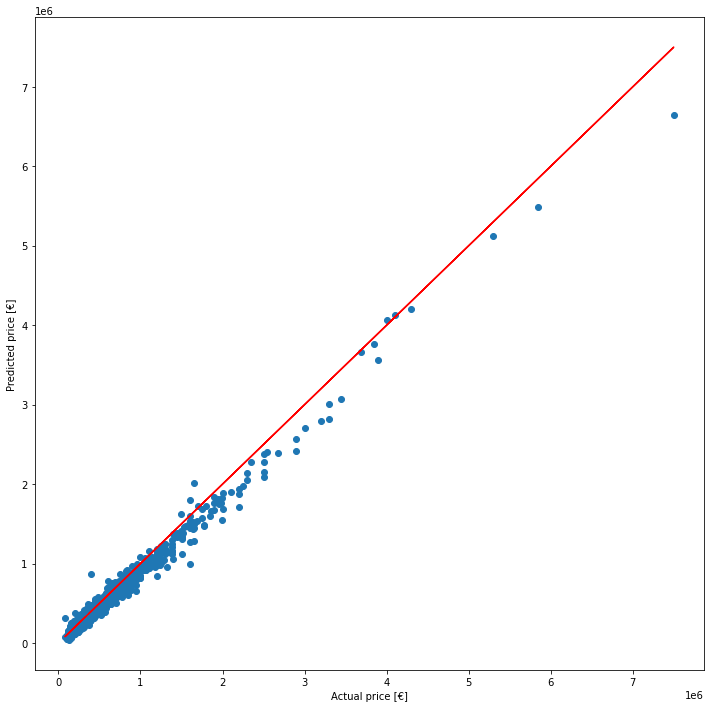

In [88]:
print('MAE:', metrics.mean_absolute_error(y_test_inverse, y_pred_inverse))
print('MSE:', metrics.mean_squared_error(y_test_inverse, y_pred_inverse))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_inverse, y_pred_inverse)))
print('VarScore:', metrics.explained_variance_score(y_test_inverse, y_pred_inverse))
 
plt.figure(figsize=(12, 12))
plt.scatter(y_test_inverse, y_pred_inverse)
 
plt.plot(y_test_inverse, y_test_inverse, 'r')
 
plt.xlabel('Actual price [€]')
plt.ylabel('Predicted price [€]')

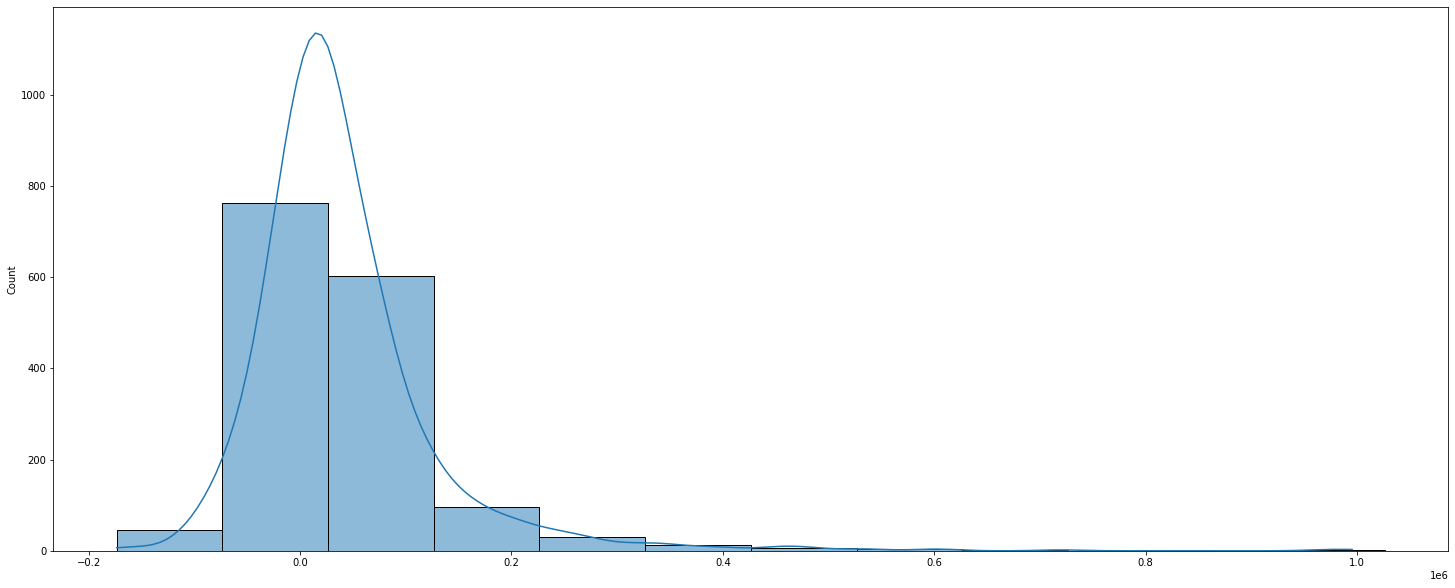

In [83]:
fig_dims = (25, 10)
fig, ax = plt.subplots(figsize=fig_dims)
 
residuals = (y_test_inverse - y_pred_inverse)
sb.histplot(data=residuals, binwidth=100000, ax=ax, kde=True)

## Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
import datetime

In [ ]:
# Clear any logs from previous runs
rm -rf ./logs/